In [1]:
import pandas as pd
import re
from collections import Counter
from sklearn.metrics import mutual_info_score

In [2]:
df = pd.read_csv('data/train.csv')

In [94]:
def get_flag_words(df: pd.DataFrame) -> list:
    neutral_words = ['you', 'my', 'so', 'or', 'him', 'in', 'at', 'as', 'of', 'it', 'like', 'your', 'after', 'with',
                     'were']

    weird_words = ['la', 'http://t']  # todo remove them

    frequency_threshold = len(df) * 0.005
    mutual_info_threshold = 0.0025

    text = df['text'].str.cat(sep=' ')

    text = re.sub('\s+', ' ', text)
    text = re.sub('\?+', ' ?', text)
    text = re.sub('\.+', ' .', text)
    text = re.sub('\!+', ' !', text)

    all_words = (text.replace('#', '')  # another feature
                 .replace('-', '')
                 .replace('.', '')
                 .replace('?', '')  # another feature
                 .replace('!', '')  # another feature
                 .replace("'", '')
                 .lower().strip())

    all_words = re.sub('\s+', ' ', all_words)

    word_counts = Counter(all_words.split(' '))

    result = []
    for word, frequency in word_counts.most_common():
        if frequency < frequency_threshold:
            break

        if len(word) == 1:
            continue

        if word.isnumeric():
            continue

        # if word in neutral_words:
        #     continue

        # if word in weird_words:
        #     print('please fix this')
        #     continue

        mi = mutual_info_score(df['target'], df['text'].str.contains(re.escape(word)))
        if mi > mutual_info_threshold:
            print(f'{word} has repeated {frequency} times with mi score of {mi}')
            result.append(word)

    return result

In [95]:
flag_words = get_flag_words(df)

http://t has repeated 4295 times with mi score of 0.036680015427320745
in has repeated 1972 times with mi score of 0.004512894187841343
of has repeated 1823 times with mi score of 0.0032452299743019053
you has repeated 795 times with mi score of 0.0124997383743823
my has repeated 675 times with mi score of 0.005459949669095562
it has repeated 570 times with mi score of 0.0033406648397702188
at has repeated 536 times with mi score of 0.004630254303250092
like has repeated 346 times with mi score of 0.003402352127705989
as has repeated 329 times with mi score of 0.004288213528497897
so has repeated 316 times with mi score of 0.0052681157287080005
your has repeated 293 times with mi score of 0.003449947864279948
after has repeated 257 times with mi score of 0.003553456767549118
fire has repeated 247 times with mi score of 0.010596438661290605
or has repeated 203 times with mi score of 0.008698294535774032
were has repeated 166 times with mi score of 0.0027662886225055076
storm has repeate

In [96]:
flag_words.append("?")
flag_words.append("!")

## todo:
- http://t
- la
- ?
- !

In [90]:
flag_words

['http://t',
 'fire',
 'storm',
 'suicide',
 'bomb',
 'fires',
 'killed',
 'crash',
 'train',
 'families',
 'bombing',
 'fatal',
 'wildfire',
 'bomber',
 'homes',
 'flood',
 'debris',
 'wild',
 'rain',
 'spill',
 'bag',
 'migrants',
 'outbreak']

In [17]:
from sklearn.model_selection import train_test_split

# todo:
keywords 

In [39]:
seed = 22
df_train_valid, df_test = train_test_split(df, test_size=0.2, random_state=seed)
df_train, df_valid = train_test_split(df_train_valid, test_size=0.25, random_state=seed)

y_train = df_train.target
y_valid = df_valid.target
y_test = df_test.target

df_train.drop(columns=['target', 'location'], inplace=True)
df_valid.drop(columns=['target', 'location'], inplace=True)
df_test.drop(columns=['target', 'location'], inplace=True)

In [40]:
df_train

,id,keyword,text
1843,2649,crashed,Heard #SKH on the radio for the first time. Al...
1789,2568,crash,The Next Financial Crash. 'The Writing is on t...
5710,8147,rescuers,VIDEO: 'We're picking up bodies from water' - ...
2870,4124,drought,Pretty neat website to get the latest drought ...
6683,9576,thunder,Waldo Thunder 12U Cooperstown Dreams Park 2015...
...,...,...,...
5202,7428,obliterated,Uribe just obliterated a baseball.
2821,4055,displaced,@lizhphoto When I have so much shit going on i...
7156,10253,war%20zone,This bed looks like a war zone.
5618,8016,refugees,#retweet Cameroon repatriating about 12000 Nig...


In [78]:
def get_input_1(df: pd.DataFrame, flag_words: list):
    x = df.copy()
    for flag_word in flag_words:
        x['_has_' + flag_word + '_'] = x['text'].str.contains(re.escape(flag_word)).astype(int)
    x.drop(columns=['text', 'keyword', 'id'], inplace=True)
    return x.values

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [100]:
from typing import Callable


def draw_roc_and_get_auc(get_input: Callable, flag_words: list):
    x_train = get_input(df_train, flag_words)
    model = LogisticRegression()
    model.fit(x_train, y_train)
    x_valid = get_input(df_valid, flag_words)
    y_prob = model.predict_proba(x_valid)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, y_prob)

    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1])
    
    plt.xlabel('FPR')
    plt.ylabel('TPR')

    return roc_auc_score(y_valid, y_prob)

0.5966331913700335

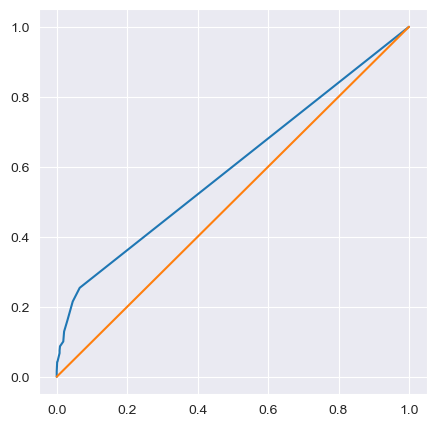

In [83]:
draw_roc_and_get_auc(get_input_1, flag_words)  # flag_words with omitting wierd words and 0.01 threshold

0.6838266996161733

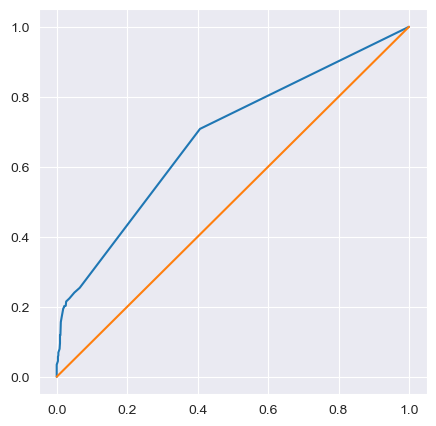

In [86]:
draw_roc_and_get_auc(get_input_1, flag_words)  # flag_words with wierd words and 0.01 threshold 

0.7096000490737333

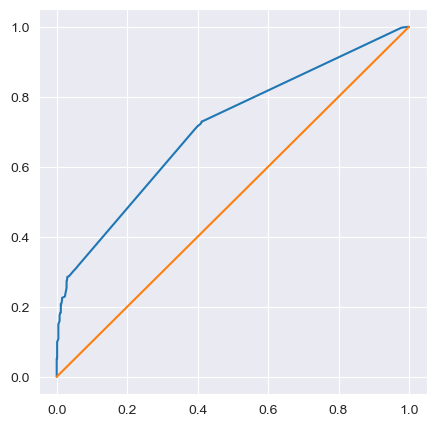

In [89]:
draw_roc_and_get_auc(get_input_1, flag_words)  # flag_words with wierd words and 0.005 threshold 

0.7261668156404999

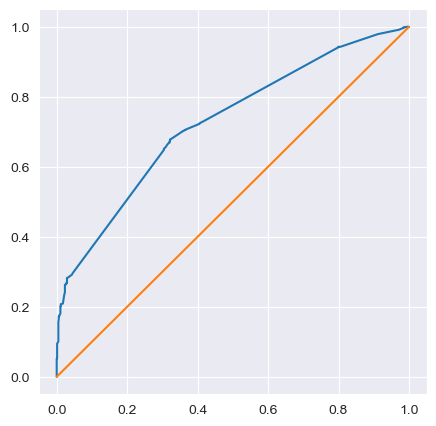

In [93]:
draw_roc_and_get_auc(get_input_1, flag_words) 
# flag_words with wierd words and 0.005 threshold + ? and !

0.7679013968487652

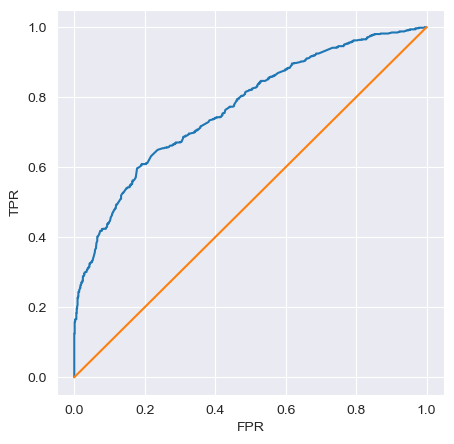

In [101]:
draw_roc_and_get_auc(get_input_1, flag_words)
# flag_words with wierd words and neutral words and 0.005 threshold + ? and !